In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
embedding_layer = layers.Embedding(1000, 5)

In [4]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.02869526,  0.04434964, -0.03563113, -0.00360793,  0.0377708 ],
       [ 0.03290145, -0.00590444, -0.02881416,  0.02392273,  0.04450181],
       [-0.03896227, -0.02406421,  0.02911783, -0.00319487,  0.01999346]],
      dtype=float32)

In [5]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

In [6]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split=(tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True, as_supervised=True
)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete1YTYB8/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete1YTYB8/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete1YTYB8/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [7]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [8]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [9]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 681,  968, 4994, ...,    0,    0,    0],
       [ 519,  132,   23, ...,  958, 1247, 7975],
       [  62,   27,   96, ...,    0,    0,    0],
       ...,
       [5862, 2884,  102, ...,    0,    0,    0],
       [  12,  641,    7, ...,    0,    0,    0],
       [  62, 6744, 1831, ...,    0,    0,    0]])

In [10]:
embedding_dim = 16

model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)                          
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20
)

Epoch 1/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.5082 - accuracy: 0.6939 - val_loss: 0.3943 - val_accuracy: 0.8750
Epoch 2/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.2874 - accuracy: 0.8831 - val_loss: 0.3218 - val_accuracy: 0.8700
Epoch 3/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.2316 - accuracy: 0.9087 - val_loss: 0.3499 - val_accuracy: 0.8400
Epoch 4/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1999 - accuracy: 0.9252 - val_loss: 0.4337 - val_accuracy: 0.8650
Epoch 5/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1770 - accuracy: 0.9338 - val_loss: 0.3655 - val_accuracy: 0.8700
Epoch 6/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.1580 - accuracy: 0.9416 - val_loss: 0.2908 - val_accuracy: 0.8850
Epoch 7/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.1447 - accuracy: 0.9485 - val_loss: 0.3918 - val_ac

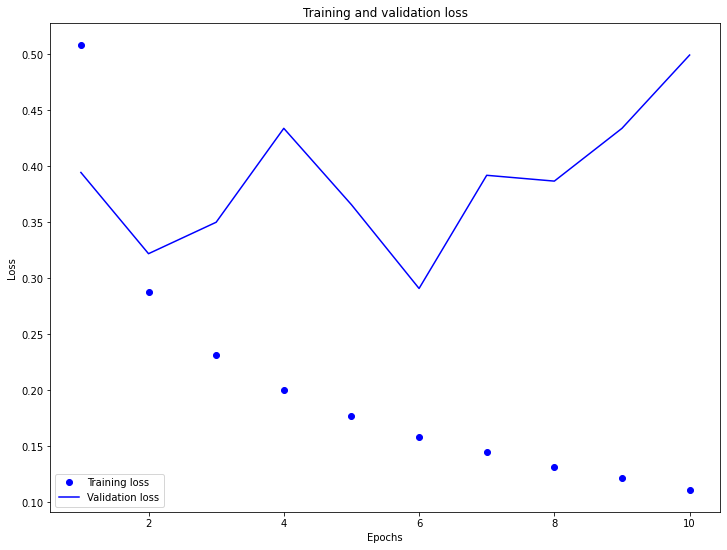

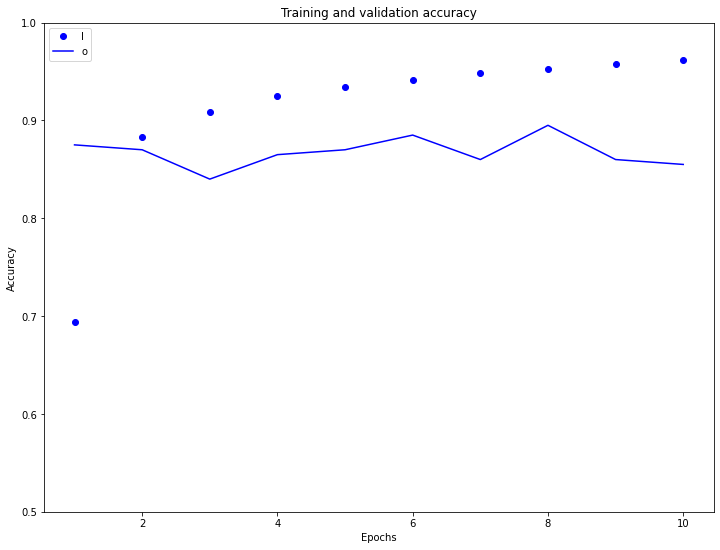

In [12]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend("lower right")
plt.ylim((0.5,1))
plt.show()

In [13]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(8185, 16)


In [14]:
import io

encoder = info.features['text'].encoder

out_v = io.open("vecs.tsv", "w", encoding="utf-8")
out_m = io.open("meta.tsv", "w", encoding="utf-8")

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1]
  out_m.write(word+"\n")
  out_v.write("\t".join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [15]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("vecs.tsv")
  files.download("meta.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>